## Data processing and plotting for figure09

This notebook describes the data acquisition for figure09 (Annealing of a cryogenically irradiated coated-conductor) and allows the user to regenerate and modify this figure based on the data provided in ~/data/figure09/

**Notes and caveats on sample irradiation:**

The sample was first irradiated at 21 K, and were able to obtain two small fluence steps. The Ic measurement files labeled "irradiated" correspond to the sample after last of these fluence steps, and before any annealing occurs.

Unfortunately, the 1.2 MeV proton flux vs. time could not be recorded on that day due to an instrument malfunction, and therefore the starting fluence is unknown. However, the total fluence is expected to be in the 1e20 protons/m$^2$ based on a typical Ic vs fluence curve at 20 K; see e.g. figure 8.

In [109]:
%matplotlib notebook
import hts_fitting as hts
from scipy.optimize import curve_fit
import matplotlib, matplotlib.pyplot as plt
import os, numpy as np, pandas as pd

# Change this to ma
parentDirectory = '../data/figure09/'

### Temperature vs time

The DATAQ had to be restarted several times during the anneal, therefore the temperature vs time data is in 4 separate sets of anneal curves, which can be loaded from **cxch-temperature.xlsx.**

**Notes and caveats on sample annealing:**

* The PID parameters were not very well tuned at the time this data was acquired, resuling in overshoots of a few Kelvins and some dampening ripples (Temperature vs time) in the first half hour of each anneal step.
* The 154 K anneal step lasted for nearly two hours, which may incur a larger than expected recovery.
* At the time this data was acquired, the range was controlled by 3 on/off heaters and one PID controlled heater. This causes inconsistent warmups and cooldowns, which can affect the "isochronal" nature of the experiment by changing the thermal budget available to the REBCO on each step in a slightly irregular way.
* Anneal steps 271-277 K have conspicuous drops and rises in temperature during the anneal plateau.

<IPython.core.display.Javascript object>


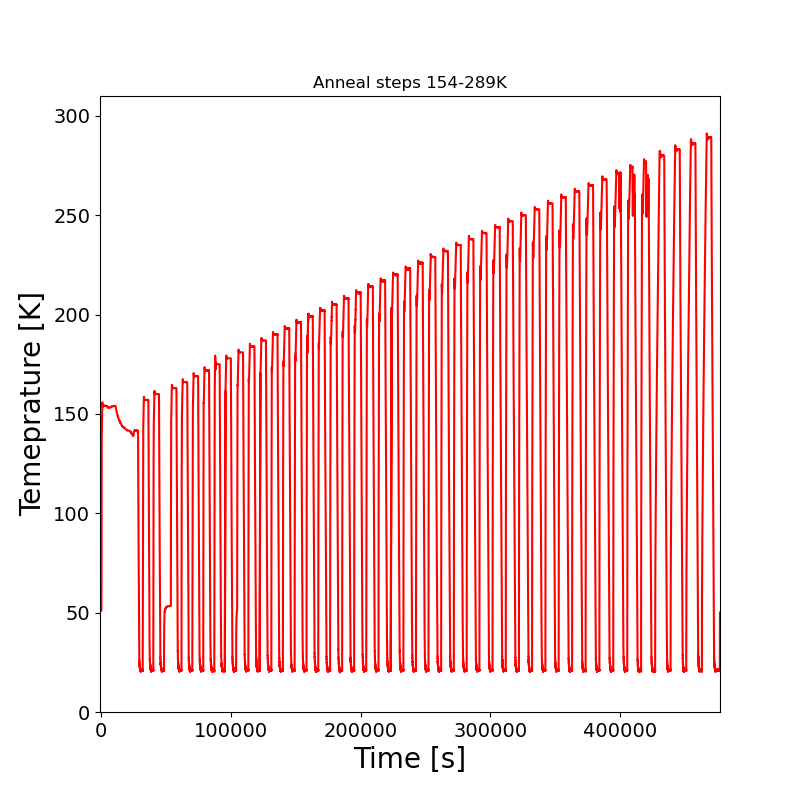

(-1000.0, 477083.13)

In [201]:
index = 2 # Change this to look at other sets of Temperature vs Time curves.
anneal_ranges = ['100-142K','145-151K','154-289K','292-301K']

master = pd.read_excel(parentDirectory+'master.xlsx', usecols=[1, 2, 3, 6], names=['sname', 't0', 't1', 'fname'], skiprows=1)

data = pd.read_excel(parentDirectory+'cxch-temperature.xlsx', sheet_name=anneal_ranges[index], usecols=[0, 1], names=['time', 'temperature'], skiprows=1)

fig, ax = plt.subplots()
ax.plot(data.time, data.temperature, color='r')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temeprature [K]')
ax.set_title('Anneal steps {}'.format(anneal_ranges[index]))
ax.set_ylim(0, 310)
ax.set_xlim(-1000, data.time.max())

### Batch process the average temperature during each anneal step and the resulting Ic(T=21K)

Results are automatically updated in master.xlsx

In [202]:
#### Average temperature during anneal

means, stds = [], []
for sname in [s for s in master.sname.unique() if type(s) == str]:
    cut = (master.sname == sname)
    data = pd.read_excel(parentDirectory+'cxch-temperature.xlsx', sheet_name=sname, usecols=[0, 1], names=['time', 'temperature'], skiprows=1)
    for t0, t1 in zip(master.t0[cut], master.t1[cut]):
        means.append(data[(t0 <= data.time) & (data.time < t1)].temperature.mean())
        stds.append(data[(t0 <= data.time) & (data.time < t1)].temperature.std())

df = pd.DataFrame({
    'means': means, 
    'stds': stds
})
with pd.ExcelWriter(parentDirectory+'master.xlsx', engine='openpyxl',if_sheet_exists='replace', mode='a') as writer:
    pd.DataFrame(df).to_excel(writer, sheet_name='output-annealT', index=False, header=False)
    

#### Resulting Ic(T=21 K) values

ffunction = 'powerLaw'
vMaxSet = 5e-6

df = pd.read_excel(parentDirectory+'master.xlsx', sheet_name='master', usecols=[7], names=['fname'], skiprows=2)

ics, ns, icerrs, nerrs, tTARs, tTARerrs = [], [], [], [], [], []

for fname in df.fname:
    fpath = parentDirectory+fname
    ic, n, current, voltage, chisq, pcov = hts.fitIcMeasurement(fpath, fformat='mit', function=ffunction, vMax=vMaxSet, vb=False)
    icerr, nerr = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1])
    _, _, temperature = hts.readIV(fpath)
    tTAR, tTARerr = np.nanmean(temperature[1][-10:]), np.nanstd(temperature[1][-10:])
    
    ics.append(ic)
    icerrs.append(icerr)
    ns.append(n)
    nerrs.append(nerr)
    tTARs.append(tTAR)
    tTARerrs.append(tTARerr)
        
    
data = {
    'ic': ics,
    'icerr': icerrs,
    'n': ns,
    'nerr': nerrs,
    'tTAR': tTAR,
    'tTARerr': tTARerr,
}

with pd.ExcelWriter(parentDirectory+'master.xlsx', engine='openpyxl',if_sheet_exists='replace', mode='a') as writer:
    pd.DataFrame(data).to_excel(writer, sheet_name='output-icnt', index=False, header=False)

/Users/alexisdevitre/Documents/GitHub/2024-CryoHTS-Facility/code/hts_fitting.py:57: RuntimeWarning: invalid value encountered in log
  current, voltage = np.log(current), np.log(voltage)
/Users/alexisdevitre/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


## Nice plot for publication!

In [198]:
names = ['irradiated', 'annealT', 'annealT_std', 'ic', 'icerr', 'icT', 'icTerr']
df = pd.read_excel(parentDirectory+'master.xlsx', sheet_name='master', skiprows=1, usecols=[0, 5, 6, 8, 9, 12, 13], names=names)

pristine_mean = df[df.irradiated == 0].mean()
pristine_std = df[df.irradiated == 0].std()

annealSteps_mean = df[df.irradiated == 1].groupby(df.annealT).mean()
annealSteps_std = df[df.irradiated == 1].groupby(df.annealT).std()

pristine = pristine_mean.ic
annealT = annealSteps_mean.annealT
values = annealSteps_mean.ic.values/pristine_mean.ic
errorbar = values*np.sqrt((annealSteps_std.ic.values/annealSteps_mean.ic.values)**2+(np.ones_like(annealSteps_mean.ic.values)*pristine_std.ic/pristine_mean.ic)**2)

np.sqrt((annealSteps_std.ic.values/annealSteps_mean.ic.values)**2+(np.ones_like(annealSteps_mean.ic.values)*(pristine_std.ic/pristine_mean.ic))**2)


array([0.00678897, 0.00415017, 0.00481144, 0.00363487, 0.00458153,
       0.00324175, 0.00387099, 0.00383745, 0.00446182, 0.00575758,
       0.00382172, 0.00319758, 0.00301709, 0.00370437, 0.00482275,
       0.00508937, 0.00421083, 0.00337016, 0.00312971, 0.00351334,
       0.00329344, 0.00380363, 0.00397584, 0.00424955, 0.00416346,
       0.0051224 , 0.00287752, 0.00369188, 0.00336165, 0.00432615,
       0.00409011, 0.0033777 , 0.00305423, 0.00277131, 0.00320882,
       0.00426696, 0.00391696, 0.00371985, 0.00328621, 0.00311018,
       0.00415419, 0.00426026, 0.00392052, 0.00427199, 0.00390993,
       0.00597574, 0.00603125, 0.00492007, 0.00528355, 0.00427592,
       0.0035056 , 0.00485287, 0.00372534, 0.00360269, 0.00365102,
       0.00459383, 0.00445192, 0.00453685, 0.00362579, 0.00694478,
       0.00521414, 0.00458768, 0.00430834, 0.00465832, 0.00909976,
       0.004804  , 0.00506669, 0.00701593, 0.37509395])

<IPython.core.display.Javascript object>


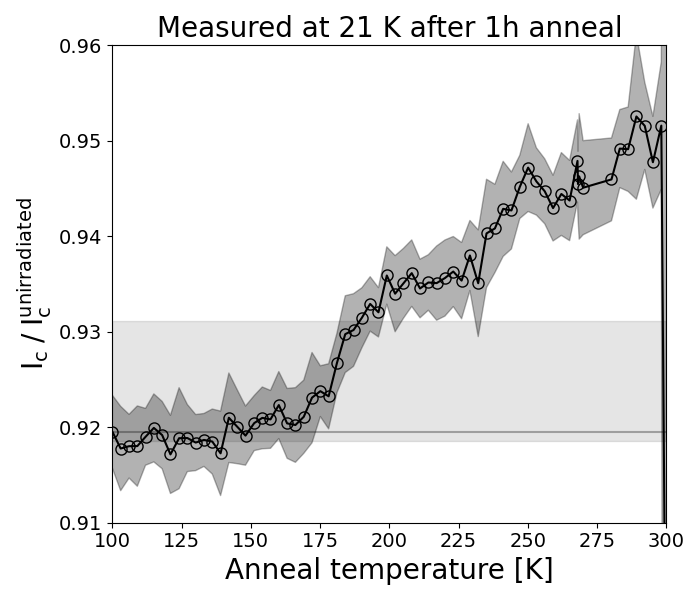

In [199]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.set_xlim(100, 300)
ax.set_ylim(.91, 0.96)
ax.set_xlabel('Anneal temperature [K]')
ax.set_ylabel('$\mathrm{I_c\;/\;I_c^{unirradiated}}$')
ax.set_title('Measured at 21 K after 1h anneal', fontsize=20)

ax.axhline(values[1], color='k', alpha=.3)
ax.fill_between([100, 300], [values[0]-errorbar[0], values[0]-errorbar[0]], [values[0]+errorbar[0], values[0]+errorbar[0]], color=c, alpha=.1)

ax.fill_between(annealT, values-errorbar, values+errorbar, color=c, alpha=.3, label='STD')
ax.plot(annealT, values, mfc='None', marker='o', color=c, label='Mean (8 points)')

fig.tight_layout()

<IPython.core.display.Javascript object>


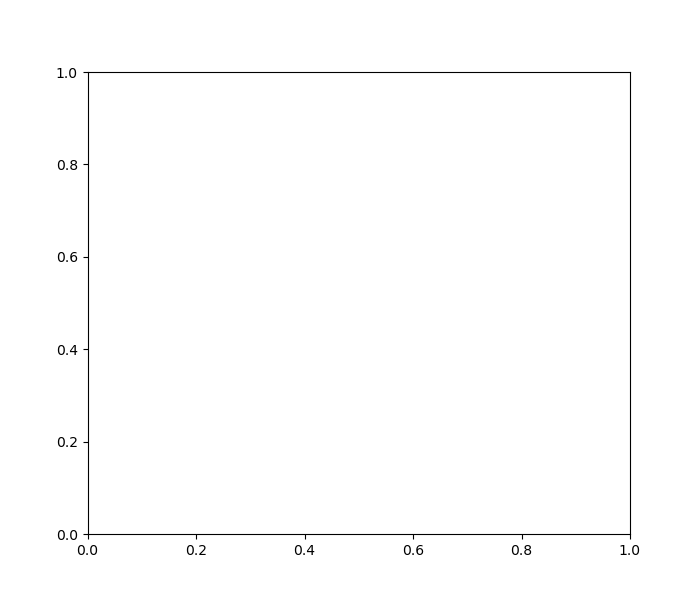

FileNotFoundError: [Errno 2] No such file or directory: 'data/figure11-anneal/asc_data.xlsx'

In [48]:

c = 'k'



#ax.legend(loc='upper left')


ax.set_rasterized(True)
plt.savefig('figures/svg/anneal.svg')